(0.375369135825255, 0.7557766454010213, 0.4966667574466806)
>> LINAC #1
Tracking element #1 (s = 0.0 m, -1.60 nC, 3.0 GeV, SourceBasic, stage 0)
Tracking element #2 (s = 5.0 m, -1.60 nC, 34.5 GeV, StageNonlinear1D, stage 1)
Tracking element #3 (s = 13.7 m, -1.60 nC, 34.5 GeV, InterstageELEGANT, stage 1)
Tracking element #4 (s = 18.7 m, -1.60 nC, 65.4 GeV, StageNonlinear1D, stage 2)
Tracking element #5 (s = 30.8 m, -1.60 nC, 65.4 GeV, InterstageELEGANT, stage 2)
Tracking element #6 (s = 35.8 m, -1.60 nC, 96.2 GeV, StageNonlinear1D, stage 3)
Tracking element #7 (s = 50.4 m, -1.60 nC, 96.2 GeV, InterstageELEGANT, stage 3)
Tracking element #8 (s = 55.4 m, -1.60 nC, 126.4 GeV, StageNonlinear1D, stage 4)
Tracking element #9 (s = 72.3 m, -1.60 nC, 126.4 GeV, InterstageELEGANT, stage 4)
Tracking element #10 (s = 77.3 m, -1.60 nC, 157.5 GeV, StageNonlinear1D, stage 5)
Tracking element #11 (s = 96.1 m, -1.60 nC, 157.5 GeV, InterstageELEGANT, stage 5)
Tracking element #12 (s = 101.1 m, -1.60 nC, 

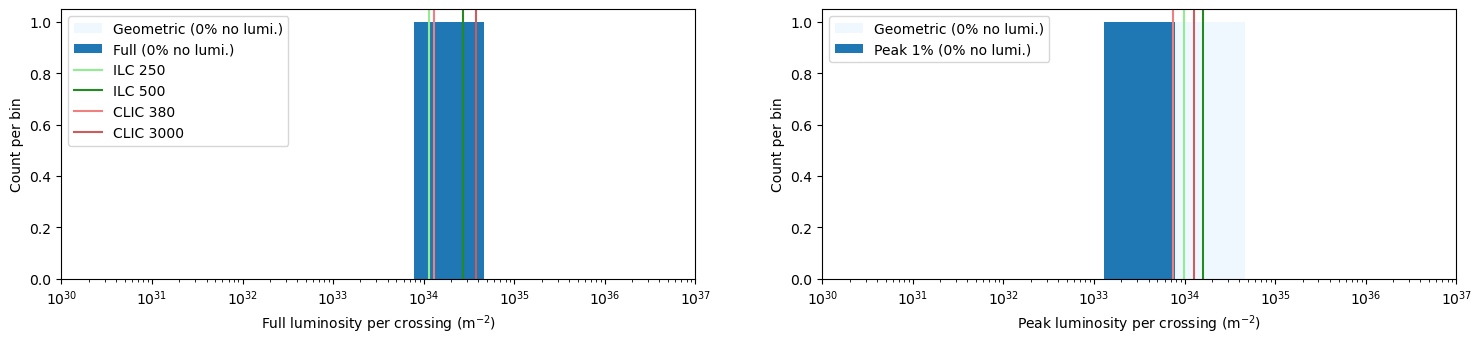

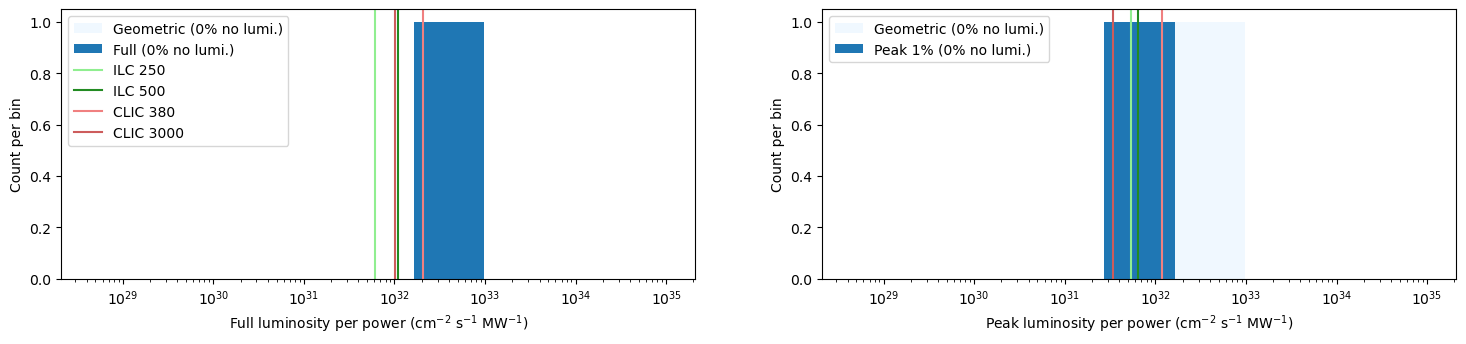

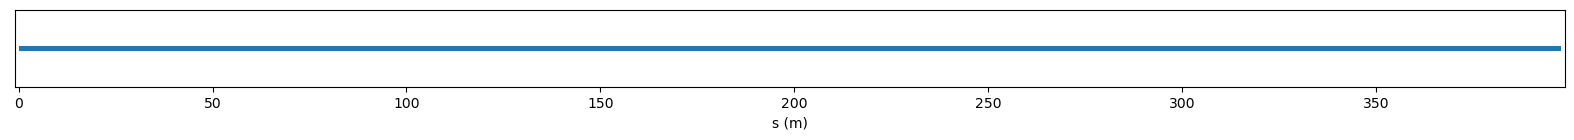

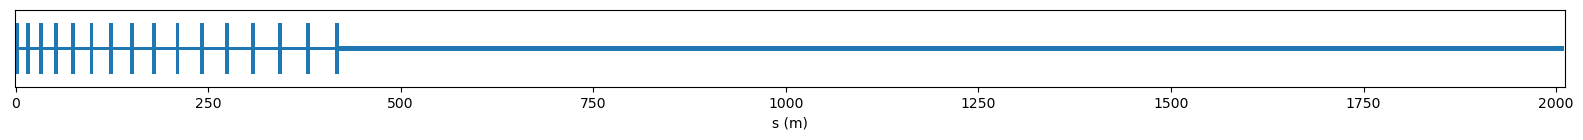

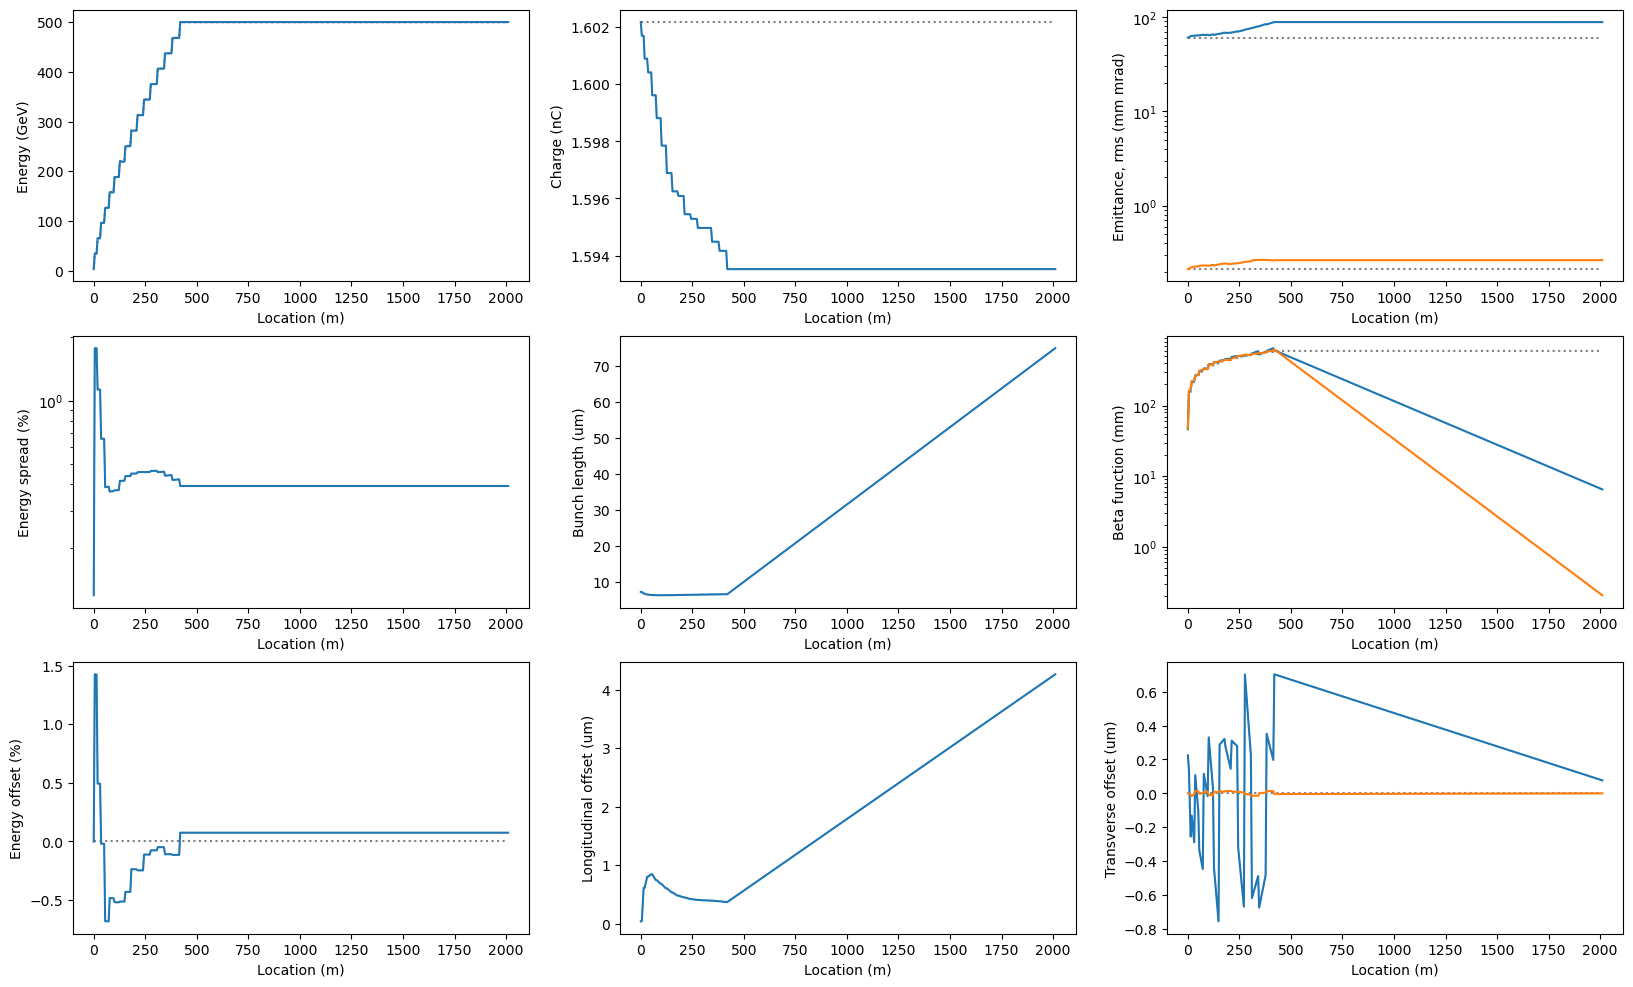

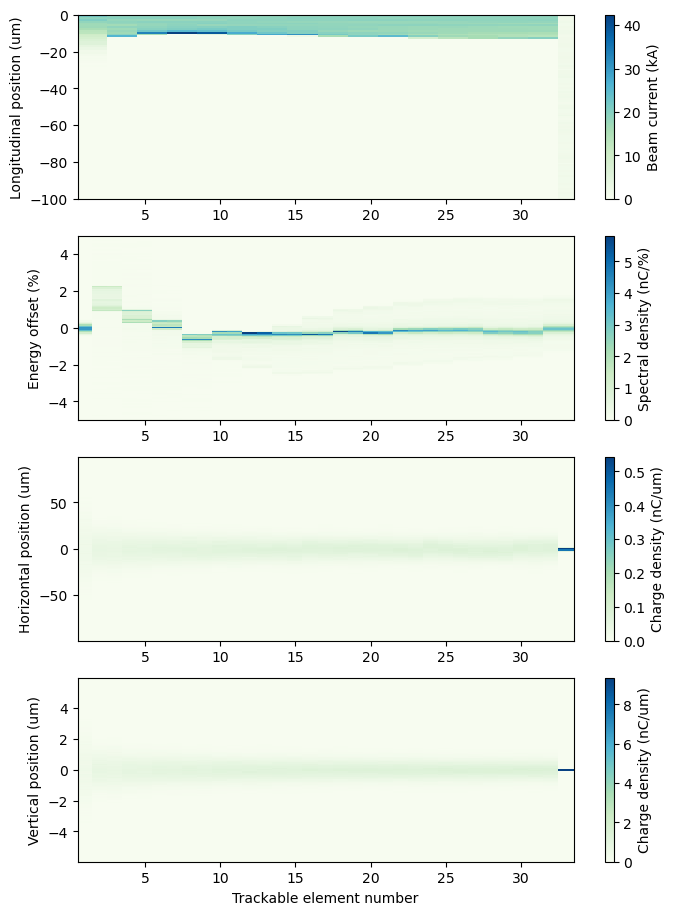

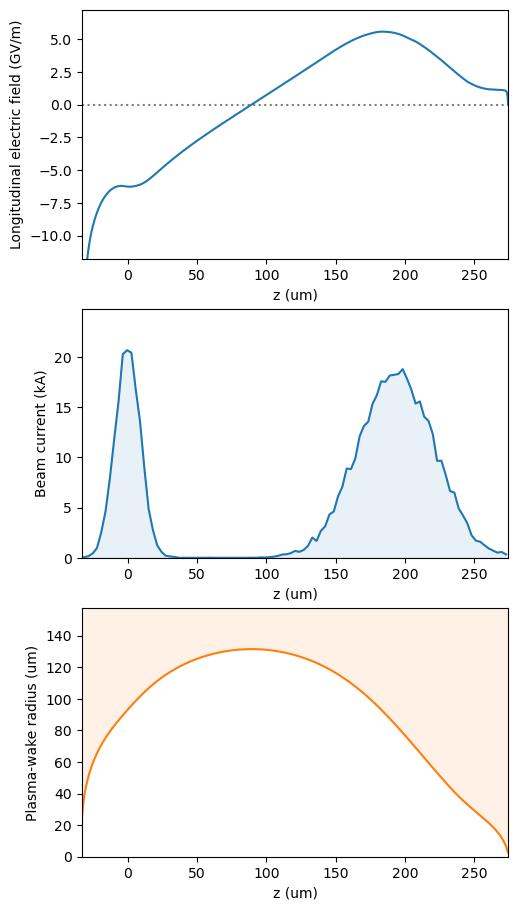

In [1]:
import sys
sys.path.append('../')
from opal import SourceBasic, StageNonlinear1D, InterstageBasic, InterstageELEGANT, Linac, BeamDeliverySystemBasic, InteractionPointGUINEAPIG, Collider
from opal.utilities.plasmaphysics import beta_matched
from opal.utilities import SI
import numpy as np

E_HZ = 250e9
E_Z = 91.2e9

# energyAsymmetry = E_Z/(E_HZ/4)
energyAsymmetry = 4 #  factor increase in e- energy
compressionFactor = 4 # factor decrease in both bunch lengths
chargeAsymmetry = 2 # factor decrease in e- charge
emittanceScaling = 1.5 # exponent of scaling of e- emittance

f = 1e4

N0 = 2e10
E0 = 3e9

Ecofm = E_HZ # E_HZ # 380e9
Ee = (Ecofm/2)*energyAsymmetry
Ep = (Ecofm/2)/energyAsymmetry

Nstages = int(np.ceil((Ee-E0)/Ep))
DeltaE = (Ee-E0)/Nstages

eta_d2w = 0.75
eta_w2b = 0.5
eta_d2b = eta_d2w*eta_w2b

Ne = N0 / chargeAsymmetry
Np = N0 * chargeAsymmetry

Ed = Ep
Nd = N0 / chargeAsymmetry / eta_d2b

Qd = -SI.e * Nd

Pcool = 100e3

P_dump = f * abs(Qd) * Ep * (1-eta_d2w)
P_stage = f * abs(Qd) * Ep * eta_d2w * (1-eta_w2b)
Lstage = P_stage / Pcool

Ez = DeltaE/Lstage

if chargeAsymmetry == 3:
    zd = 64.8e-6 + 74e-6
    sigzd = 17.9e-6
    n0 = 3e22
    sigze = 5.5e-6
elif chargeAsymmetry == 2:
    zd = 120e-6 + 74e-6
    sigzd = 27.6e-6
    n0 = 1.5e22
    sigze = 9e-6
elif chargeAsymmetry == 1:
    zd = 343e-6 + 74e-6
    sigzd = 50.8e-6
    n0 = 0.33e22
    sigze = 16e-6

Npart = 10000

# define driver
driver = SourceBasic()
driver.Q = Qd # [C]
driver.E0 = Ed # [eV]
driver.emitnx = 10e-6 # [m rad]
driver.emitny = driver.emitnx
driver.betax = 30e-3 * 5 # [m]
driver.betay = driver.betax 
driver.relsigE = 0.01
driver.sigz = sigzd # [m]
driver.z = zd # [m]
driver.Npart = round(Npart*sigzd/sigze)
driver.wallplugEfficiency = 0.5
driver.acceleratingGradient = 25e6

# define driven stage
stage = StageNonlinear1D()
stage.driverSource = driver
stage.deltaE = DeltaE
stage.L = Lstage # [m]
stage.n0 = n0 # [m^-3]
stage.rampBetaMagnification = 10

# define electron bunch
electrons = SourceBasic()
electrons.Q = - SI.e * Ne # [C]
electrons.E0 = E0
electrons.relsigE = 0.0015
electrons.sigz = sigze # [m]
electrons.emitnx = 10e-6 * energyAsymmetry**(emittanceScaling) # [m rad]
electrons.emitny = 0.035e-6 * energyAsymmetry**(emittanceScaling) # [m rad]
electrons.betax = beta_matched(stage.n0, E0)*stage.Bmag # [T]
electrons.betay = electrons.betax # [T]
electrons.z = 0
electrons.Npart = Npart
electrons.wallplugEfficiency = driver.wallplugEfficiency

stage.track(electrons.track())
#stage.plotWakefield(electrons.track(), saveToFile="Figure2.pdf", includeWakeRadius=False)
print(stage.energyEfficiency())

# define positron bunch
positrons = SourceBasic()
positrons.Q = SI.e * Np # [C]
positrons.E0 = Ep
positrons.relsigE = electrons.relsigE
positrons.sigz = 300e-6 / compressionFactor
positrons.emitnx, positrons.emitny = 10e-6, 0.035e-6 # [m rad]
positrons.betax = 13e-3 / energyAsymmetry
positrons.betay = 0.41e-3 / energyAsymmetry
positrons.Npart = electrons.Npart
positrons.L = 0
positrons.wallplugEfficiency = driver.wallplugEfficiency*Ep/(5e9+Ep)

# define interstage
interstage = InterstageELEGANT()
#interstage = InterstageBasic()
interstage.beta0 = lambda E: beta_matched(stage.n0, E)*stage.Bmag # [T]
interstage.Bdip = 0.5 # [T]
interstage.Ldip = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.enableISR = True
interstage.enableCSR = True

ebds = BeamDeliverySystemBasic()
ebds.beta_waist_x = 13e-3 * (Ecofm/E_HZ) * energyAsymmetry**(1-emittanceScaling)
ebds.beta_waist_y = 0.41e-3 * (Ecofm/E_HZ) * energyAsymmetry**(1-emittanceScaling)
ebds.sigz = positrons.sigz

pbds = BeamDeliverySystemBasic()
pbds.beta_waist_x = 13e-3 * (Ecofm/E_HZ) / energyAsymmetry
pbds.beta_waist_y = 0.41e-3 * (Ecofm/E_HZ) / energyAsymmetry
pbds.sigz = positrons.sigz

# define linac
elinac = Linac(electrons, stage, interstage, ebds, Nstages=Nstages)
plinac = Linac(positrons, bds=pbds)

# define
ip = InteractionPointGUINEAPIG(enableWaistShift=True)

# track particles
collider = Collider(elinac, ip, plinac)
ebeam, pbeam = collider.run(f"HAHF_{Ecofm/1e9}GeV_{positrons.sigz*1e6:.0f}um_energy{energyAsymmetry}_charge{chargeAsymmetry}_emittance{emittanceScaling}_new", shots=1, overwrite=True)

# plot survery and beam evolution
Beff_turnaround = 1 # [T]
Lturnaround = 2*np.pi*(driver.E0/(Beff_turnaround*SI.c))
print(f"# ENERGY / CHARGE ASYMMETRY = {energyAsymmetry} / {chargeAsymmetry} ({Ee/1e9:.1f}/{Ep/1e9:.1f} GeV, {Ne/1e10:.1f}/{Np/1e10:.1f}e10, {positrons.sigz*1e6:.0f} um rms long, {energyAsymmetry**(emittanceScaling)}-fold scaled emittance)")
print(f"l_facility = {collider.totalLength() + Lturnaround:.0f} m ({elinac.length()-ebds.length():.0f}/{ebds.length():.0f} m e-linac/BDS, {pbds.length():.0f} m p-BDS, {driver.length():.0f} m RF linac, {Lturnaround:.0f} m driver U-turn)")
print(f"P_wall     = {collider.energyUsage()*f/1e6:.1f} MW (at {f/1e3} kHz)")
print(f"L_full     = {collider.fullLuminosityPerCrossing()/1e34:.2f} ub^-1")
print(f"L_peak     = {collider.peakLuminosityPerCrossing()/1e34:.2f} ub^-1")
print(f"L/P_full   = {collider.fullLuminosityPerPower()/1e30:.2f} cm^-2 s^-1 MW^-1")
print(f"L/P_peak   = {collider.peakLuminosityPerPower()/1e30:.2f} cm^-2 s^-1 MW^-1")
print(f"N_stages   = {Nstages}")
print(f"l_stage    = {Lstage:.1f} m")
print(f"E_z        = {Ez/1e9:.1f} GV/m")
collider.plotLuminosity()
collider.plotLuminosityPerPower()
plinac.plotSurvey()
elinac.plotSurvey()
elinac.plotEvolution()
elinac.plotWaterfalls()
stage.plotWakefield(electrons.track())